## **Overview**
This tutorial introduces the key **sinogram preprocessing functions** in `nDTomo`, designed to handle raw pencil beam CT data before reconstruction. Preprocessing is essential to correct for experimental artefacts such as baseline offsets, beam intensity fluctuations, misalignment, and center of rotation drift — all of which can severely degrade the quality of the reconstructed image.

These tools operate on both **2D sinograms** and **3D sinogram stacks** (e.g., spectral or z-resolved data), and are modular so you can tailor your preprocessing pipeline to your specific dataset and experimental setup.

## **Objectives**
By the end of this tutorial, you will:
- Apply `nDTomo` functions to correct **background offsets**, **beam drift**, **motor jitter**, and **rotation misalignment**.
- Understand how each function transforms the sinogram and why it’s necessary.
- Build a robust preprocessing workflow for high-quality tomographic reconstruction.

## **Sinogram Preprocessing Functions**

### **1. `airrem` – Air Background Removal**
Removes additive background signal (air signal) by estimating and subtracting it from edge rows of the sinogram. This is useful when portions of the sinogram (top/bottom) contain no sample.

- **Modes**: `"both"`, `"top"`, `"bottom"` — determines where to sample air signal
- **Offset (`ofs`)**: Number of rows used to estimate the background
- **Column selection (`coli`, `colf`)**: Restrict estimation to specific columns
- **Supports**: 2D and 3D sinograms (correction applied per projection)

**Why use it?**  
To suppress air-related background levels that would otherwise interfere with reconstruction or downstream fitting.

### **2. `scalesinos` – Sinogram Normalization**
Normalizes each projection by its total integrated intensity to account for fluctuations in beam intensity or sample attenuation.

- Computes a **scaling factor per projection**
- Divides each projection to normalize its sum relative to the maximum
- Automatically handles 2D and 3D sinograms

**Why use it?**  
To equalize projection contributions and reduce artefacts from flux instability, detector gain drift, or sample thickness variations.

### **3. `sinocentering` – Center of Rotation (COR) Alignment**
Identifies and corrects the **center of rotation offset** by comparing projections at 0° and 180°.

- Searches for COR by minimizing the standard deviation of flipped projections
- Works with 180° or 360° scans
- Optionally selects spectral channels to use
- Applies correction using interpolation
- Supports 2D and 3D inputs

**Why use it?**  
To ensure the reconstructed image is centered and symmetric. Misaligned rotation axes produce severe artefacts and incorrect geometries.

### **4. `sinocomcor` – Common-Mode Correction / Motor Jitter Correction**
Aligns projections based on their **center of mass** (COM), compensating for scan motor jitter or random translation shifts.

- Uses the COM of each projection
- Shifts projections using linear interpolation
- Works for 2D and 3D sinograms

**Why use it?**  
To correct for lateral misalignments between projections caused by motor jitter or detector drift, improving reconstruction sharpness.

## **How This Tutorial Works**
- We begin with a raw sinogram or stack of sinograms.
- Each preprocessing step is visualized to show its effect.
- Intermediate results are plotted after each correction.
- The final output is a clean, centered, and normalized sinogram ready for reconstruction (e.g., via filtered backprojection or DLSR).

## **Why This Matters**
- Preprocessing directly impacts the **fidelity of tomographic reconstructions**
- Many artefacts (e.g., ringing, misalignments, loss of contrast) can be traced back to poor sinogram conditioning
- These tools provide a **physically informed, user-adjustable**, and lightweight preprocessing pipeline for pencil beam CT

Let’s now apply each of these functions in sequence and observe their effects.

# Preprocessing and correcting sinograms
### **A Tutorial on sinogram handling**

In [104]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import iradon, radon
from tqdm import tqdm

from nDTomo.sim.phantoms import SheppLogan
from nDTomo.methods.xrays import simulate_synchrotron_intensity
from nDTomo.tomo.sinograms import scalesinos, airrem, sinocomcor, sinocentering


First we create a phantom object that we will use for our simulations

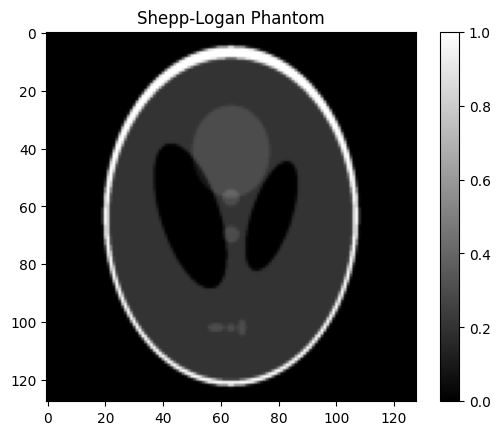

In [105]:
npix = 128
img = SheppLogan(npix)

plt.figure(1);plt.clf()
plt.imshow(img, cmap='gray')
plt.title('Shepp-Logan Phantom')
plt.colorbar()
plt.show()


### Initial FBP Reconstruction Without Artefacts

Before applying any corrections or artefact removal steps, it's important to visualize the baseline 
performance of filtered back projection (FBP) on a clean synthetic sinogram. This provides a 
reference for evaluating the impact of subsequent preprocessing steps.

In this section, we perform FBP reconstruction on a simulated sinogram (e.g., Shepp-Logan phantom) 
without introducing any noise, background signal, or alignment issues. This allows us to confirm 
that:
- The sinogram is correctly generated.
- The FBP algorithm is functioning as expected.
- The spatial resolution and feature contrast are consistent with the known phantom structure.

This reconstruction serves as a "ground truth" benchmark, and visual comparison with corrected 
versions later helps quantify improvements.

The number of angles is 128


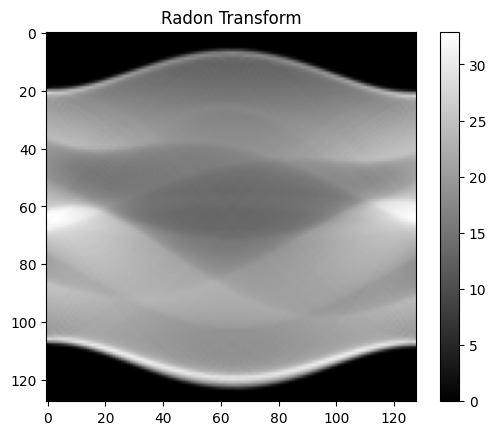

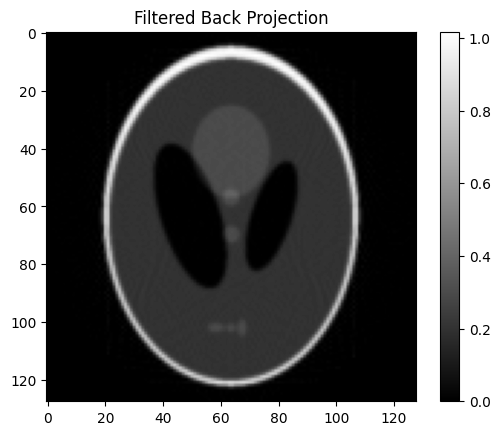

In [106]:
scan = 180
theta = np.arange(0, scan, scan/npix) 
print('The number of angles is', len(theta))

s = radon(img, theta) 

fbp = iradon(s, theta, filter_name='ramp', output_size=npix)
fbp[fbp < 0] = 0    

plt.figure(1);plt.clf()
plt.imshow(s, cmap='gray')
plt.title('Radon Transform')
plt.colorbar()
plt.show()

plt.figure(2);plt.clf()
plt.imshow(fbp, cmap='gray')
plt.title('Filtered Back Projection')
plt.colorbar()
plt.show()


### Air Signal Removal from Sinograms

During X-ray CT sinograms often include a background signal from air 
attenuation or scattering that does not contain useful sample information. This background appears 
as a constant or slowly varying offset in each projection.

The `airrem` function removes this unwanted background signal by averaging pixel intensities at 
the edges of the sinogram—either the top, bottom, or both—and subtracting this average from 
the entire projection.

Key benefits of this step:
- Enhances image contrast in reconstructions.
- Reduces artefacts caused by detector offsets or flat-field mismatch.
- Makes subsequent corrections (e.g., centering, alignment) more robust.

You can tune how many rows are used (`ofs`) and restrict the averaging to a subset of columns 
(`coli`, `colf`) if needed.

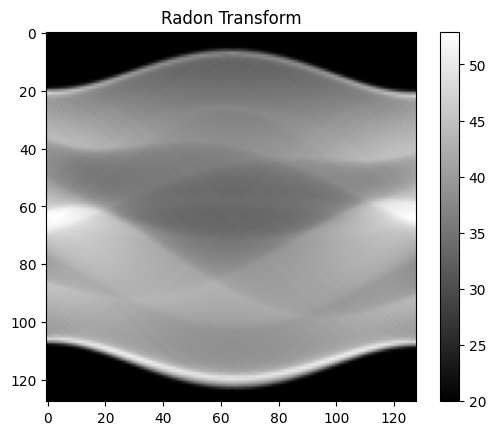

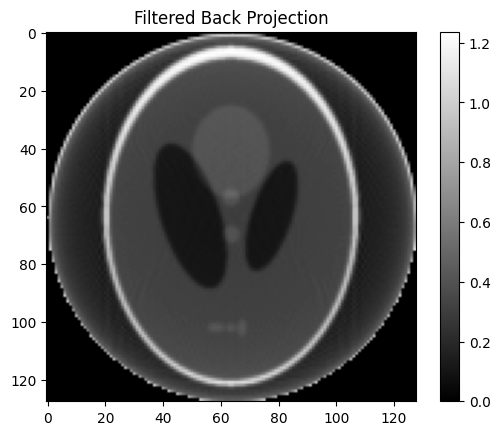

  0%|          | 0/128 [00:00<?, ?it/s]

ValueError: operands could not be broadcast together with shapes (128,) (2,) (128,) 

In [107]:
sn = np.copy(s)

bkg = 20
sn = sn + bkg

fbp = iradon(sn, theta, filter_name='ramp', output_size=npix)
fbp[fbp < 0] = 0    

plt.figure(1);plt.clf()
plt.imshow(sn, cmap='gray')
plt.title('Radon Transform')
plt.colorbar()
plt.show()

plt.figure(2);plt.clf()
plt.imshow(fbp, cmap='gray')
plt.title('Filtered Back Projection')
plt.colorbar()
plt.show()


sn = airrem(sn, ofs = 2, method="both", coli=0, colf=2)
fbp = iradon(sn, theta, filter_name='ramp', output_size=npix)
fbp[fbp < 0] = 0

plt.figure(1);plt.clf()
plt.imshow(sn, cmap='gray')
plt.title('Radon Transform')
plt.colorbar()
plt.show()

plt.figure(2);plt.clf()
plt.imshow(fbp, cmap='gray')
plt.title('Filtered Back Projection')
plt.colorbar()
plt.show()


### Sinogram Normalization Using `scalesinos`

In many tomographic experiments, it's assumed that the total X-ray intensity (i.e., total scattering 
or transmission) for each projection should remain constant. However, experimental conditions 
such as beam fluctuations, sample movement, or detector drift can introduce global intensity 
variations across projections.

The `scalesinos` function corrects for these variations by normalizing each projection based on its 
**total integrated intensity**. Specifically, it computes the sum of all pixel values in each projection, 
compares this to the maximum total intensity observed, and scales the projection accordingly.

This normalization ensures that:
- Each projection contributes equally to the final reconstruction.
- Global contrast fluctuations are minimized.
- Reconstructions are more robust to beam instabilities and sample positioning errors.

For 3D sinograms, the normalization is applied slice-by-slice across 
the spectral or z-dimension.

In [ ]:
sf = simulate_synchrotron_intensity(200, 0.75, num_topups=2)

plt.figure(1);plt.clf()
plt.plot(sf)
plt.title("Simulated Synchrotron Beam Intensity")
plt.xlabel("Time Index")
plt.ylabel("Relative Intensity")
plt.grid(True)
plt.show()

sn = np.copy(s)

for ii in range(sn.shape[1]):
    sn[:, ii] = sn[:, ii] * sf[ii]

fbp = iradon(sn, theta, filter_name='ramp', output_size=npix)
fbp[fbp < 0] = 0    

plt.figure(1);plt.clf()
plt.imshow(sn, cmap='gray')
plt.title('Radon Transform')
plt.colorbar()
plt.show()

plt.figure(2);plt.clf()
plt.imshow(fbp, cmap='gray')
plt.title('Filtered Back Projection')
plt.colorbar()
plt.show()

sn = scalesinos(sn)
fbp = iradon(sn, theta, filter_name='ramp', output_size=npix)
fbp[fbp < 0] = 0    

plt.figure(1);plt.clf()
plt.imshow(sn, cmap='gray') 
plt.title('Scaled Radon Transform')
plt.colorbar()
plt.show()

plt.figure(2);plt.clf()
plt.imshow(fbp, cmap='gray')
plt.title('Filtered Back Projection')
plt.colorbar()
plt.show()


### Rotation Axis Correction Using `sinocentering`

Precise knowledge of the center of rotation (COR) is essential for accurate tomographic reconstruction. 
If the COR is misaligned, it can introduce severe artefacts such as doubling, blurring, or streaking 
in the reconstructed image.

The `sinocentering` function estimates and applies a correction for COR misalignment by:
1. Comparing the projection at 0° with the flipped projection at 180°.
2. Searching within a user-defined range (`crsr`) for the optimal COR that minimizes the standard 
   deviation between the two.
3. Shifting the sinogram data accordingly using linear interpolation.

#### Key features of `sinocentering`:
- Supports both 2D and 3D sinograms.
- The correction is applied uniformly across the entire sinogram or volume.
- In 3D mode, a subset of spectral channels can be specified via the `channels` parameter.
  These selected channels are used **only for computing the COR** — the correction is then 
  applied to **all channels** uniformly. This is useful when some channels contain artefacts or noise 
  that could bias the COR estimation.
- Handles both 180° and 360° scans using the `scan` parameter.
- Provides an optional progress bar during execution (`pbar=True`).

This function is typically used after motor jitter correction (`sinocomcor`) and intensity normalization, 
and just before reconstruction.

In [ ]:

sn = np.copy(s)

ofs = 3
sn = np.roll(sn, ofs, axis = 0)

fbp = iradon(sn, theta, filter_name='ramp', output_size=npix)
fbp[fbp < 0] = 0    

plt.figure(1);plt.clf()
plt.imshow(sn, cmap='gray')
plt.title('Radon Transform')
plt.colorbar()
plt.show()

plt.figure(2);plt.clf()
plt.imshow(fbp, cmap='gray')
plt.title('Filtered Back Projection')
plt.colorbar()
plt.show()

sn = sinocentering(sn, crsr=5, interp=True, scan=180, channels = None, pbar=True)
fbp = iradon(sn, theta, filter_name='ramp', output_size=npix)
fbp[fbp < 0] = 0  

plt.figure(1);plt.clf()
plt.imshow(sn, cmap='gray')
plt.title('Radon Transform')
plt.colorbar()
plt.show()

plt.figure(2);plt.clf()
plt.imshow(fbp, cmap='gray')
plt.title('Filtered Back Projection')
plt.colorbar()
plt.show()



### Motor Jitter Correction Using Center of Mass (COM) Alignment

Mechanical instabilities or motor jitter can cause each projection in a sinogram to be slightly 
misaligned along the translation axis. These small shifts accumulate and lead to blurred or 
distorted reconstructions.

The `sinocomcor` function corrects these shifts by:
1. Computing the center of mass (COM) for each projection using its intensity profile.
2. Aligning all projections so that their COM matches that of the first projection.
3. Applying this correction using linear interpolation, optionally clipping extrapolated values.

This correction improves:
- Edge sharpness and alignment in reconstructions.
- The quality of subsequent centering or segmentation steps.
- Accuracy in time-resolved or dynamic tomography.

By default, the COM correction uses raw offsets, but more advanced options are also available.

In [ ]:


sn = np.copy(s)

for ii in range(1, sn.shape[1]):
    ofs = np.random.randint(-3, 3)
    sn[:, ii] = np.roll(sn[:, ii], ofs)


fbp = iradon(sn, theta, filter_name='ramp', output_size=npix)
fbp[fbp < 0] = 0    

plt.figure(1);plt.clf()
plt.imshow(sn, cmap='gray')
plt.title('Radon Transform')
plt.colorbar()
plt.show()

plt.figure(2);plt.clf()
plt.imshow(fbp, cmap='gray')
plt.title('Filtered Back Projection')
plt.colorbar()
plt.show()

sn = sinocomcor(sn, interp=False)
sn = sinocentering(sn, crsr=5, interp=True, scan=180, channels = None, pbar=False)

fbp = iradon(sn, theta, filter_name='ramp', output_size=npix)
fbp[fbp < 0] = 0    

plt.figure(1);plt.clf()
plt.imshow(sn, cmap='gray') 
plt.title('Scaled Radon Transform')
plt.colorbar()
plt.show()


plt.figure(2);plt.clf()
plt.imshow(fbp, cmap='gray')
plt.title('Filtered Back Projection')
plt.colorbar()
plt.show()


### Sine Wave-Based COM Correction for Periodic Jitter

In some imaging setups, misalignments caused by mechanical vibrations may follow a periodic pattern, 
such as sinusoidal drift from oscillating components or rotating stages.

The `sinocomcor` function provides an option (`sine_wave=True`) to fit a sine wave to the computed 
COM offsets. This fitted curve is then used to correct the projections, rather than using noisy raw COM data.

Advantages of sine fitting:
- Provides smoother and more physically realistic corrections.
- Reduces sensitivity to noise in individual projections.
- Captures periodic trends in the system's mechanical behavior.

If `sine_wave_plot=True` is enabled, the function will also generate a diagnostic plot showing the 
raw COM offsets and the fitted sine curve. This helps verify that the fit is appropriate and aligns 
with the observed misalignment pattern.

Use this option when you suspect the jitter is not random but instead driven by periodic motion.

In [ ]:
sn = np.copy(s)

xold = np.arange(sn.shape[0])
for ii in range(1, sn.shape[1]):
    ofs = np.random.rand(1)[0]*3
    xnew = xold + ofs
    sn[:, ii] = np.interp(xnew, xold, sn[:, ii], left=0, right=0)
    
fbp = iradon(sn, theta, filter_name='ramp', output_size=npix)
fbp[fbp < 0] = 0    

plt.figure(1);plt.clf()
plt.imshow(sn, cmap='gray')
plt.title('Radon Transform')
plt.colorbar()
plt.show()

plt.figure(2);plt.clf()
plt.imshow(fbp, cmap='gray')
plt.title('Filtered Back Projection')
plt.colorbar()
plt.show()

sn = sinocomcor(sn, interp=False, sine_wave=True, sine_wave_plot=True, pbar = False)
sn = sinocentering(sn, crsr=5, interp=True, scan=180, channels = None, pbar=True)

plt.figure(1);plt.clf()
plt.imshow(sn, cmap='gray')
plt.title('Radon Transform')
plt.colorbar()
plt.show()

fbp = iradon(sn, theta, filter_name='ramp', output_size=npix)
fbp[fbp < 0] = 0 

plt.figure(2);plt.clf()
plt.imshow(fbp, cmap='gray')
plt.title('Filtered Back Projection')
plt.colorbar()
plt.show()

